In [37]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split #Random sample selection
#from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
#Data importation
dataframe = pd.read_csv("datosModelo.csv")
X = [] #Trajectories vector
y = [] #Labels vector
ws = [] #Works vector

for i in range(12000):
    X.append(np.array(dataframe["Tr_{}".format(i)]))
    y.append(int(dataframe["Label_{}".format(i)][0]))
    ws.append(float(dataframe["W_{}".format(i)][0]))
    
X,y,ws = np.array(X),np.array(y),np.array(ws)

#Data arrangement
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size=0.2)

#Converting data into torch tensors
XTrain = torch.from_numpy(XTrain.astype(np.float32))
XTest = torch.from_numpy(XTest.astype(np.float32))
yTrain = torch.from_numpy(yTrain.astype(np.float32))
yTest = torch.from_numpy(yTest.astype(np.float32))

#Re-scaling y data
yTest = yTest.view(yTest.shape[0],1)
yTrain = yTrain.view(yTrain.shape[0],1)

#Printing device information
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [39]:
#Model implementation
class LogisticReg(nn.Module):
    def __init__(self, inputDim, outputDim):
        super().__init__()
        self.linear = nn.Linear(inputDim, outputDim)
        
    def forward(self,x):
        prediction = torch.sigmoid(self.linear(x))
        return prediction
        
model0 = LogisticReg(inputDim = X.shape[1], outputDim = 1).to(device)

#Loss and optimization function
learningRate = 0.01
lossFunction = nn.BCELoss()
optFunction = torch.optim.Adam(params = model0.parameters(),lr = learningRate)

#Accuracy function
def accuracyFunction(yReal,yPred):
    right = torch.eq(yReal,yPred).sum().item()
    prec = (right/len(yPred))*100
    return prec

In [40]:
#Training parameters
epochs = 500
epochList = []
trainLoss = []
testLoss = []
accTrain = []
accTest = []

In [41]:
#Training loop
for epoch in range(epochs):
    #Training mode
    model0.train()
    
    #Prediction making
    yPred = model0(XTrain)
    
    #Prediction's loss
    loss = lossFunction(yPred,yTrain)
    
    # Accuracy:
    acc = accuracyFunction(yTrain, torch.round(yPred))
    
    #Zero grad
    optFunction.zero_grad()
    
    #Backpropagation
    loss.backward()
    
    #Takes a step
    optFunction.step()
    
    #Model evaluation
    model0.eval() #Converts to evaluation mode
    with torch.inference_mode(): #Stops monitoring gradients 
        
        testPred = model0(XTest)
        
        #Takes the loss of testing
        lossT = lossFunction(testPred,yTest)
        testLoss.append(lossT)
        
        accT = accuracyFunction(yTest, torch.round(testPred))
        accTest.append(accT)
        
    #Se guardan los datos para graficar
    epochList.append(epoch)
    trainLoss.append(loss.item())
    accTrain.append(acc)
    
    if epoch%10 == 0:
        print(f"Epoch : {epoch}| Training Loss: {loss:.4f}, acc: {acc:.2f}% | Test Loss : {lossT:.4f}, acc: {accT:.2f}%")

Epoch : 0| Training Loss: 0.6978, acc: 57.09% | Test Loss : 10.1087, acc: 49.38%
Epoch : 10| Training Loss: 3.6439, acc: 58.05% | Test Loss : 2.3764, acc: 63.79%
Epoch : 20| Training Loss: 2.2149, acc: 68.26% | Test Loss : 1.9883, acc: 70.21%
Epoch : 30| Training Loss: 1.2580, acc: 72.21% | Test Loss : 1.0633, acc: 74.17%
Epoch : 40| Training Loss: 0.7530, acc: 70.75% | Test Loss : 0.7410, acc: 69.83%
Epoch : 50| Training Loss: 0.5083, acc: 77.62% | Test Loss : 0.5302, acc: 76.54%
Epoch : 60| Training Loss: 0.4722, acc: 77.79% | Test Loss : 0.4820, acc: 77.54%
Epoch : 70| Training Loss: 0.4555, acc: 78.44% | Test Loss : 0.4522, acc: 79.08%
Epoch : 80| Training Loss: 0.4392, acc: 79.33% | Test Loss : 0.4488, acc: 79.54%
Epoch : 90| Training Loss: 0.4335, acc: 79.89% | Test Loss : 0.4453, acc: 79.88%
Epoch : 100| Training Loss: 0.4289, acc: 80.17% | Test Loss : 0.4401, acc: 80.33%
Epoch : 110| Training Loss: 0.4274, acc: 80.08% | Test Loss : 0.4388, acc: 80.50%
Epoch : 120| Training Loss

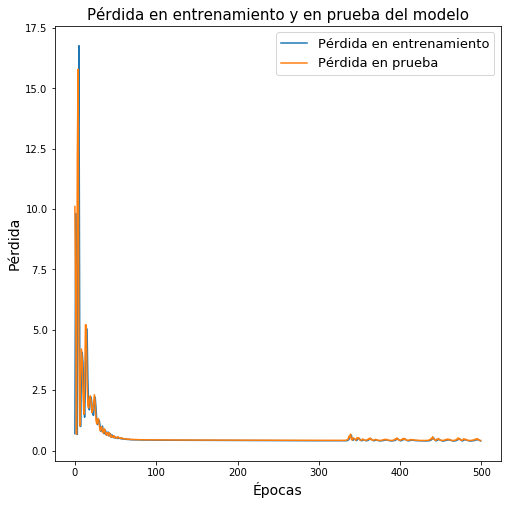

In [159]:
#Plotting training loss and test loss
plt.figure(figsize=(8,8))
plt.plot(epochList,trainLoss,label="Pérdida en entrenamiento")
plt.plot(epochList,testLoss,label="Pérdida en prueba")
plt.xlabel("Épocas",fontsize=14)
plt.ylabel("Pérdida",fontsize=14)
plt.title("Pérdida en entrenamiento y en prueba del modelo".format(learningRate),fontsize=15)
plt.legend(fontsize=13)
plt.savefig("perdidasModelo.png")

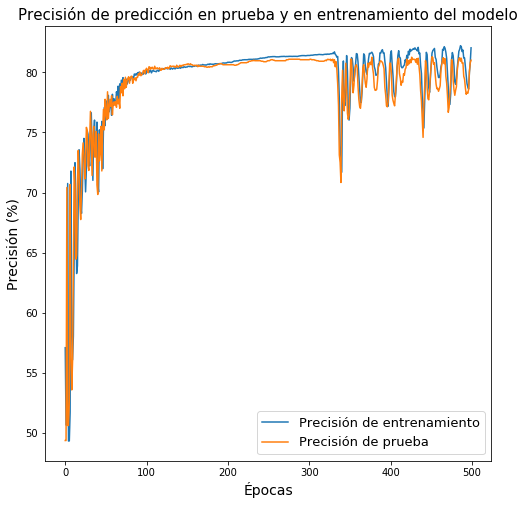

In [162]:
#Plotting accuracy over epochs
plt.figure(figsize=(8,8))
plt.plot(epochList,accTrain,label="Precisión de entrenamiento")
plt.plot(epochList,accTest,label="Precisión de prueba")
plt.xlabel("Épocas",fontsize=14)
plt.ylabel("Precisión (%)",fontsize=14)
plt.title("Precisión de predicción en prueba y en entrenamiento del modelo".format(learningRate),fontsize=15)
plt.legend(fontsize=13)
plt.savefig("precisionModelo.png")

In [49]:
#Saving the model
from pathlib import Path

modelRoute = Path("Modelos") 
modelRoute.mkdir(parents = True, exist_ok=True) 

modelName = "modeloProyecto12000Tr.pth" 
savedModelRoute = modelRoute/modelName 

torch.save(obj=model0.state_dict(),f = savedModelRoute) 

In [47]:
#Importing testing data
testDF = pd.read_csv("datosPruebaModelo.csv")

XP = [] #Trajectories vector
yP = [] #Labels vector
wsP = [] #Works vector

for i in range(1000):
    XP.append(np.array(testDF["Tr_{}".format(i)]))
    yP.append(int(testDF["Label_{}".format(i)][0]))
    wsP.append(float(testDF["W_{}".format(i)][0]))
    
XP,yP,wsP = np.array(XP),np.array(yP),np.array(wsP)

#Converting data into torch tensors
XP = torch.from_numpy(XP.astype(np.float32))
yP = torch.from_numpy(yP.astype(np.float32))

#Re-scaling y data
yP = yP.view(yP.shape[0],1)

Model accuracy: 79.5%


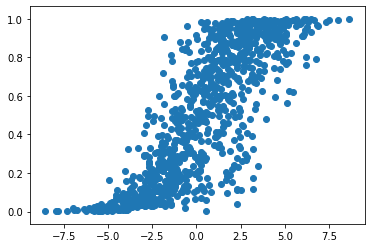

In [120]:
#Make predictions on the test data
model0.eval()

with torch.inference_mode():
    yPreds = torch.round(model0(XP))

print("Model accuracy: {}%".format(accuracyFunction(yP,yPreds)))

#Finding the arrow of time distribution
model0.eval()

with torch.inference_mode():
    dist = model0(XP)
    
dist = dist.numpy()
np.squeeze(dist)

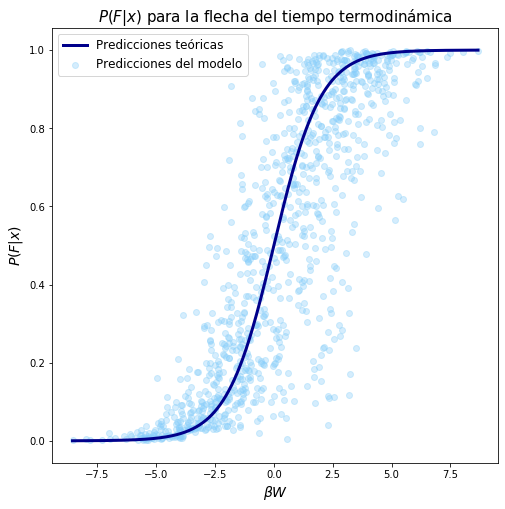

In [164]:
beta = 1
def theoreticalDist(x):
    den = 1+np.exp(-beta*(x))
    return 1/den

x = np.linspace(min(wsP),max(wsP),1000)

#Plotting the distribution
plt.figure(figsize=(8,8))
plt.title("$P(F|x)$ para la flecha del tiempo termodinámica",fontsize=15)
plt.scatter(beta*wsP,dist,label="Predicciones del modelo",alpha = 0.35,color="lightskyblue")
plt.plot(x,theoreticalDist(x),label="Predicciones teóricas",linewidth=3,color="darkblue")
plt.xlabel(r"$\beta W$",fontsize=14)
plt.ylabel("$P(F|x)$",fontsize=14)
plt.legend(fontsize=12)
plt.savefig("distProb_betaGammaK1_u05_h001_t10.png")